In [19]:
%matplotlib inline
from matplotlib import pyplot as plt

In [20]:
import pathlib

In [21]:
from collections import OrderedDict as OD

In [22]:
import numpy as np 
import pandas as pd 
import xarray as xr

**NOTE**: an alternative to the code suggested here to fix the issue with the time variable is to to run first
    
    
```
cdo settunits,days cmorph_monthly.nc cmorph_monthly_jan1998-jan2020.nc

```

in the `CDO` environment  

in order to set the calendar so that it can be read by xarray 

### set the year here 

In [23]:
year = 2022

In [24]:
dset = xr.open_dataset('../data/CMAP/precip.mon.mean.nc') 

In [25]:
dset = dset.sortby('lat')

### interpolation

In [26]:
def interp(dset, interp_factor=4, lon_name='lon', lat_name='lat'): 
    """
    Interpolate (i.e. increase the resolution) of a xarray dataset by `interp_factor`
    Parameters
    ----------
    dset : xarray.Dataset
        the xarray Dataset to interpolate
    interp_factor : int, optional
        the increase in resolution, by default 4
    lon_name : str, optional
        name of the longitude variable, by default 'lon'
    lat_name : str, optional
        name of the latitude variable, by default 'lat'
    
    Return
    ------
    
    dset : the interpolated dataset 
    """
    
    import numpy as np 
    
    target_grid = dset[[lon_name, lat_name]]
    
    target_grid[lon_name] = ((lon_name), np.linspace(target_grid[lon_name].data[0], target_grid[lon_name].data[-1], num=len(target_grid[lon_name])*interp_factor, endpoint=True))
    target_grid[lat_name] = ((lat_name), np.linspace(target_grid[lat_name].data[0], target_grid[lat_name].data[-1], num=len(target_grid[lat_name])*interp_factor, endpoint=True))
    
    dset = dset.interp_like(target_grid)
    
    return dset

In [27]:
dset = interp(dset)

In [28]:
dset

<xarray.Dataset>
Dimensions:  (time: 527, lat: 288, lon: 576)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-11-01
  * lat      (lat) float64 -88.75 -88.13 -87.51 -86.89 ... 87.51 88.13 88.75
  * lon      (lon) float64 1.25 1.872 2.493 3.115 ... 356.9 357.5 358.1 358.8
Data variables:
    precip   (time, lat, lon) float64 0.08 0.07751 0.07503 ... 0.305 0.3025 0.3
Attributes:
    Conventions:    COARDS
    title:          CPC Merged Analysis of Precipitation (includes NCEP Reana...
    platform:       Analyses
    source:         ftp ftp.cpc.ncep.noaa.gov precip/cmap/monthly
    dataset_title:  CPC Merged Analysis of Precipitation
    documentation:  https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    date_modified:  26 Feb 2019
    References:     https://www.psl.noaa.gov/data/gridded/data.cmap.html
    version:        V2212
    history:        update 12/2022 V2212
    data_modified:  2022-12-28

In [29]:
# dset['time'] = pd.to_datetime(dset['time'].data) - pd.offsets.MonthBegin(1)

### restrict the domain to [110.,-30.,280.,20.] for tthe sector plots

In [30]:
dset = dset.sel(lat=slice(-30., 20.), lon=slice(150, 360 - 90))

### calculate the climatology 

In [31]:
clim = dset.sel(time=slice('1991','2020'))

In [32]:
clim = clim.groupby(clim.time.dt.month).mean('time')

In [33]:
lon_sectors = [150, 180, (360-150), (360-120), (360-90)]
# lon_labels = ['150E','180','150W','120W','90W']
lon_labels = [u'150\u00B0E',u'180\u00B0E',u'150\u00B0W',u'120\u00B0W',u'90\u00B0W']

In [34]:
season_dict = OD()

season_dict[f"(a) January - March {year}"] = [1,3]

season_dict[f"(b) April - June {year}"] = [4,6]

season_dict[f"(c) July - September {year}"] = [7,9]

season_dict[f"(d) October - December {year}"] = [10, 12]

In [35]:
season_dict

OrderedDict([('(a) January - March 2022', [1, 3]),
             ('(b) April - June 2022', [4, 6]),
             ('(c) July - September 2022', [7, 9]),
             ('(d) October - December 2022', [10, 12])])

/tmp/ipykernel_34359/1392598420.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['30S','20S','10S','Equ.','10N','20N'], fontsize=16);
/tmp/ipykernel_34359/1392598420.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['30S','20S','10S','Equ.','10N','20N'], fontsize=16);
/tmp/ipykernel_34359/1392598420.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['30S','20S','10S','Equ.','10N','20N'], fontsize=16);
/tmp/ipykernel_34359/1392598420.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['30S','20S','10S','Equ.','10N','20N'], fontsize=16);
/tmp/ipykernel_34359/1392598420.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['30S','20S','10S','Equ.','10N','20N'], fontsize=16);
/tmp/ipykernel_34359/1392598420.py:42: UserWarning: Fix

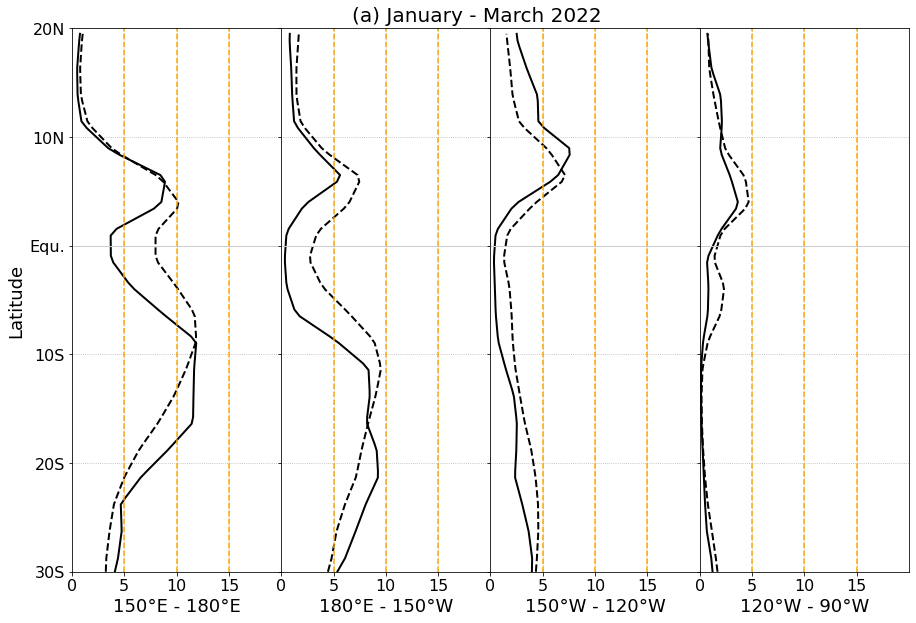

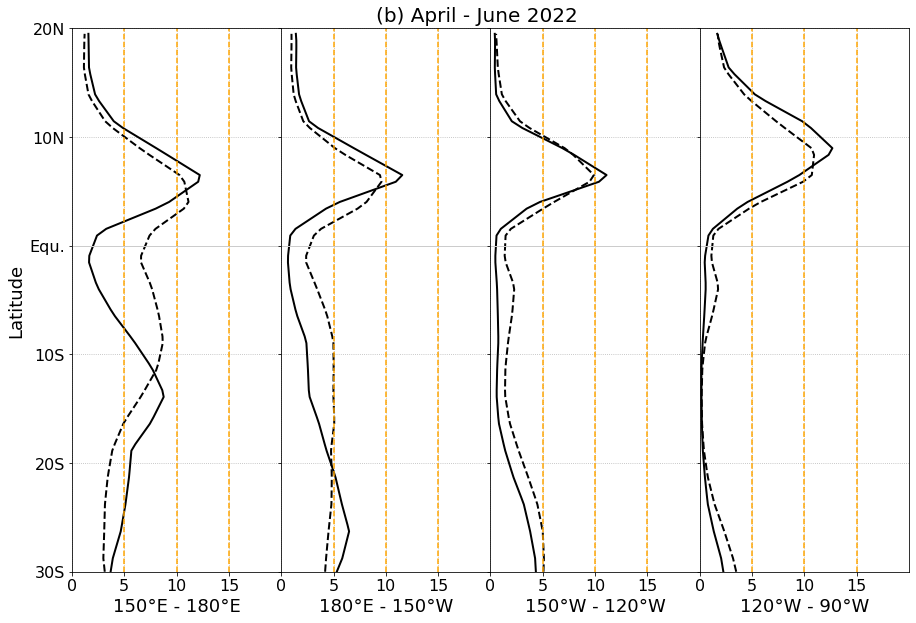

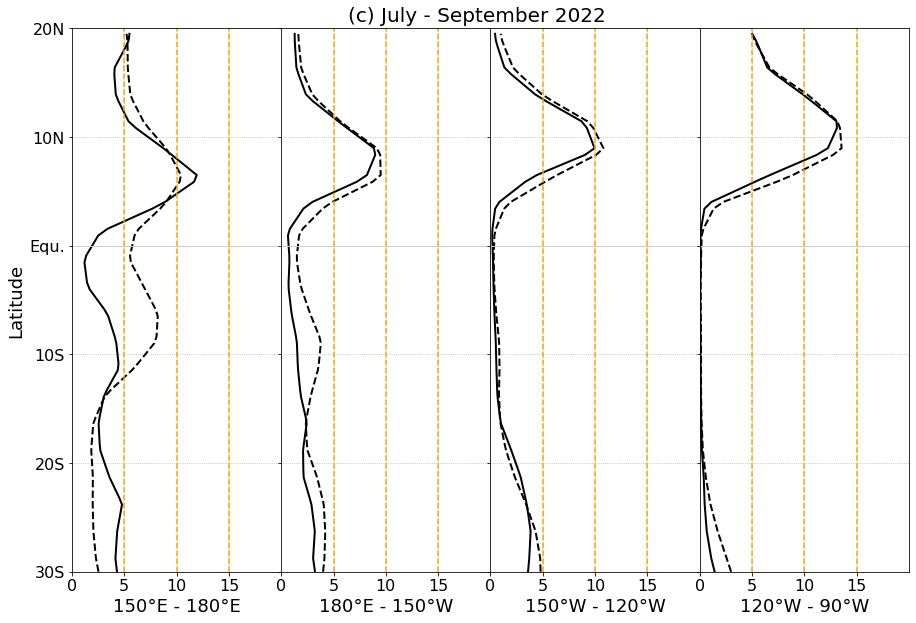

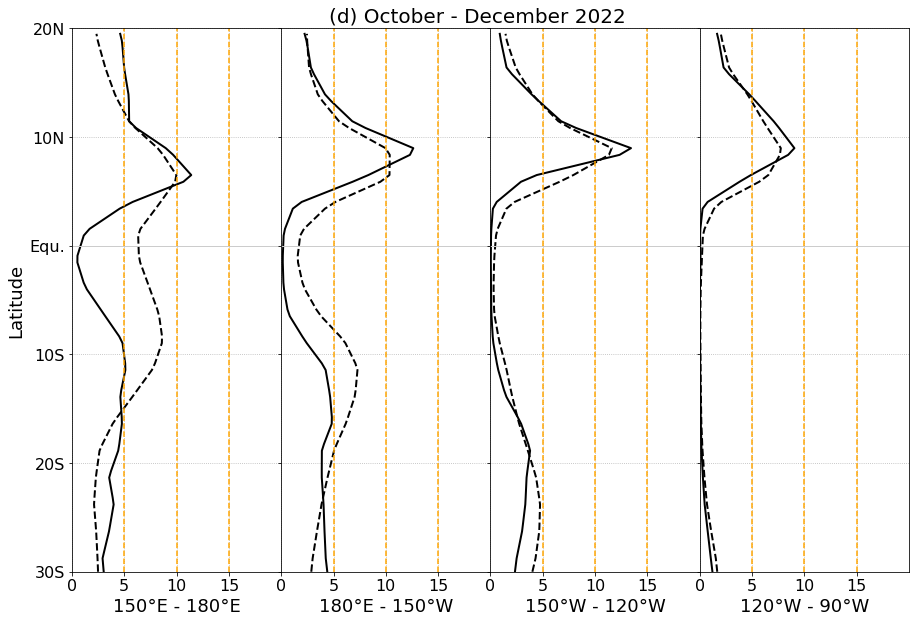

In [37]:
for seas in season_dict.keys():
    
    title = seas 
    
    seas_months = season_dict[seas]
    
    seas_range = [f"{year}-{str(seas_months[0]).zfill(2)}", f"{year}-{str(seas_months[1]).zfill(2)}"]
    
    dset_seas = dset.sel(time=slice(seas_range[0], seas_range[1])).mean('time')
    
    clim_seas = clim.sel(month=slice(seas_months[0], seas_months[1])).mean('month')
    
    f, axes = plt.subplots(ncols=4, figsize=(15,10), sharey=True)

    f.subplots_adjust(wspace=0)

    axes = axes.flatten()

    for i in range(4): 

        ax = axes[i]

        sector_seas = dset_seas.sel(lon=slice(lon_sectors[i],lon_sectors[i+1])).mean('lon')

        sector_clim = clim_seas.sel(lon=slice(lon_sectors[i],lon_sectors[i+1])).mean('lon') 

        ax.plot(sector_clim['precip'].data, sector_clim['lat'].data, color='k', lw=2, ls='--') 

        ax.plot(sector_seas['precip'].data, sector_seas['lat'].data, color='k', lw=2) 

        ax.set_ylim(-30, 20)

        ax.grid(ls=':')

        ax.axhline(0, ls='-', color='0.8', lw=1)

        for x in [5, 10, 15]: 
            ax.axvline(x, color='orange',ls='--')


        ax.set_xlim(0, 20)
        ax.set_yticklabels(['30S','20S','10S','Equ.','10N','20N'], fontsize=16); 
        ax.set_xlabel(f"{lon_labels[i]} - {lon_labels[i+1]}", fontsize=18)

        if i == 0: 
            ax.set_ylabel('Latitude', fontsize=18)
        ax.set_xticks([0,5,10, 15])
        ax.set_xticklabels([0,5,10,15], fontsize=16);

    f.suptitle(title, fontsize=20, y=0.91)
    
    f.savefig(f"../figures/CMAP_sector_plot_{seas[4:].replace('-','_').replace(' ','_')}.png", dpi=400, bbox_inches='tight', facecolor='w')
    f.savefig(f"../figures/CMAP_sector_plot_{seas[4:].replace('-','_').replace(' ','_')}.pdf", bbox_inches='tight', facecolor='w')
    f.savefig(f"../figures/CMAP_sector_plot_{seas[4:].replace('-','_').replace(' ','_')}.ps", bbox_inches='tight', facecolor='w')